In [1]:
'''Trains a simple convnet on the MNIST dataset for ONLY digits 3 and 8.
Gets to 98.25% test accuracy after 12 epochs
(there is still a lot of margin for parameter tuning).
4 seconds per epoch on a 2 GHz Intel Core i5.
'''
#imports
from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
import numpy as np
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from keras import optimizers
from keras.constraints import maxnorm
from keras.optimizers import Nadam
import theano
import matplotlib 
import matplotlib.pyplot as plt
%matplotlib inline

Using Theano backend.


## Load and preprocess data

In [2]:
#number of classes to predict, 2 or 7
num_classes = 2

# input image dimensions
img_rows, img_cols = 28, 28

#set seed for reproducibility / used inside Keras function we can't see
seed = 16
np.random.seed(seed)

# the data, shuffled and split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

#Only look at 2's and 7's
train_picks = np.logical_or(y_train==2,y_train==7)
test_picks = np.logical_or(y_test==2,y_test==7)

x_train = x_train[train_picks]
x_test = x_test[test_picks]
y_train = np.array(y_train[train_picks]==7,dtype=int)
y_test = np.array(y_test[test_picks]==7,dtype=int)


if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

#convert to binary [0,1],[1,0] -> [1],[0]
#y_train = np.argmax(y_train,axis=1)
#y_test = np.argmax(y_test,axis=1)

x_train shape: (12223, 1, 28, 28)
12223 train samples
2060 test samples


## Preview images 

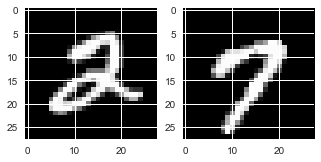

In [337]:
for i in range(0,2):
    plt.subplot(1,3,i+1)
    plt.imshow(np.squeeze(x_train[i]), cmap='gray')

## Define model

In [19]:
#build Keras model
def create_model():
    #create model
    model = Sequential()
    model.add(Conv2D(4, kernel_size=(3, 3),activation='relu',input_shape=input_shape))
    model.add(Conv2D(8, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(16, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation='softmax'))

    model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])
    
    return model 

#instantiate Keras model
model = KerasClassifier(build_fn=create_model)

## Fit default model and print score

In [21]:
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

1920/2060 [==========================>...] - ETA: 0s

0.99077669902912624

# ------------------------------------------------------------------------------
# Next we implement GridSearchCV and RandomizedSearchCV to tune parameters.  Either one can be used or both can be run to see the comparisons in performance

## Parameters to tune

In [18]:
#size of data to grab at a time
batch_size = 128
#loops on dataset
epochs = 12
#optimizers
#optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
#learning rate
#learn_rate = [0.002,0.01,0.1],
#activation for first layer
#activation = ['softmax', 'softplus', 'softsign', 'relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear']
#initializer 
#init_mode = ['uniform', 'lecun_uniform', 'normal', 'zero', 'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform']
#weight
#weight_constraint = [1, 3, 5]
#dropout percent
#dropout_rate = [0.25,0.5,0.9]
#neurons = [25,30,75,125]

##create dict of params for tuning
param_grid = dict(batch_size=batch_size, epochs=epochs)

## GridSearchCV

In [ ]:
#instatiate and test GridSearchCV 
grid_search = GridSearchCV(model,param_grid=param_grid, n_jobs=-1, verbose=1)

#fit GridSearchCV model
grid = grid_search.fit(x_train,y_train)

#best score
best_score = grid.best_score_
#best params
best_params = grid.best_params_

#print out results
print ('GridSearch Score = ' , best_score)
print ('GridSearch Best Parameters = ' , best_params)

## RandomizedSearchCV

In [ ]:
#n_iter must be no higher than the numner of parameters to check
n_iter = 5

#instatiate and test RandomizedSearch for time and score against GridSearchCV
rand_search = RandomizedSearchCV(model,param_distributions=param_grid, n_iter=n_iter, verbose=1)

#fit RandomizedSearchCV model
rand = rand_search.fit(x_train,y_train)

#best score
best_score = rand.best_score_
#best params
best_params = rand.best_params_

#print out results
print ('Randomized Score = ' , best_score)
print ('Randomized Best Parameters = ' , best_params)

# ------------------------------------------------------------------------------
# Now we initialize the best parameters when we build the Keras model

## Now that we have our parameters tuned and initialized in our Keras model we can see its performance

In [20]:
history = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))

Train on 12223 samples, validate on 2060 samples
Epoch 1/12
12223/12223 [==============================] - 4s - loss: 0.0932 - acc: 0.9728 - val_loss: 0.0503 - val_acc: 0.9835
Epoch 2/12
12223/12223 [==============================] - 4s - loss: 0.0342 - acc: 0.9889 - val_loss: 0.0373 - val_acc: 0.9859
Epoch 3/12
12223/12223 [==============================] - 4s - loss: 0.0256 - acc: 0.9927 - val_loss: 0.0298 - val_acc: 0.9903
Epoch 4/12
12223/12223 [==============================] - 4s - loss: 0.0235 - acc: 0.9927 - val_loss: 0.0246 - val_acc: 0.9913
Epoch 5/12
12223/12223 [==============================] - 4s - loss: 0.0202 - acc: 0.9938 - val_loss: 0.0224 - val_acc: 0.9927
Epoch 6/12
12223/12223 [==============================] - 4s - loss: 0.0180 - acc: 0.9947 - val_loss: 0.0219 - val_acc: 0.9922
Epoch 7/12
12223/12223 [==============================] - 4s - loss: 0.0173 - acc: 0.9946 - val_loss: 0.0235 - val_acc: 0.9932
Epoch 8/12
12223/12223 [==============================] - 4s -

<h1><font color='red'>==========================================================================</font></h1>

#                                      Visualizing model and training data 

## Plotting model Accuracy and Accuracy Loss 

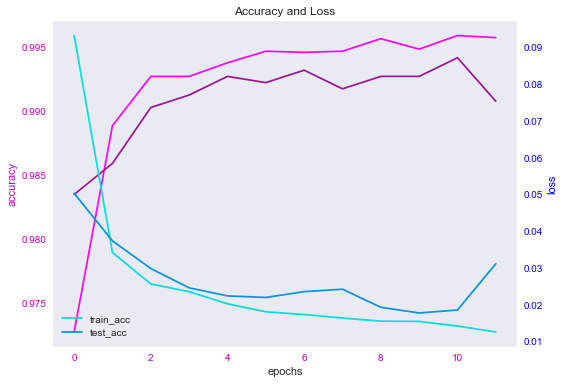

In [333]:
#custom line colors
color_acc = '#FC07EE'
color_acc2 = '#9C1794'
color_val = '#03DFDB'
color_val2 = '#0497DC'
x = np.arange(0, 12, 1)
y1 = history.history['acc']
y2 = history.history['val_acc']
y3 = history.history['loss']
y4 = history.history['val_loss']

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(x, y1, color_acc)
ax1.plot(x, y2, color_acc2)
ax2.plot(x, y3, color_val)
ax2.plot(x, y4, color_val2)

ax1.set_xlabel('epochs')
ax1.set_ylabel('accuracy', color='m')
ax2.set_ylabel('loss', color='b')

ax1.tick_params(colors='m')
ax2.tick_params(colors='b')
ax1.grid(False)
ax2.grid(False)

plt.title('Accuracy and Loss')
plt.legend(['train_loss', 'test_loss'], loc='upper left')
plt.legend(['train_acc', 'test_acc'], loc='lower left')
fig.tight_layout()
plt.show()

## Plotting the weights of each Convolutional layer

1st Convolutional Layer


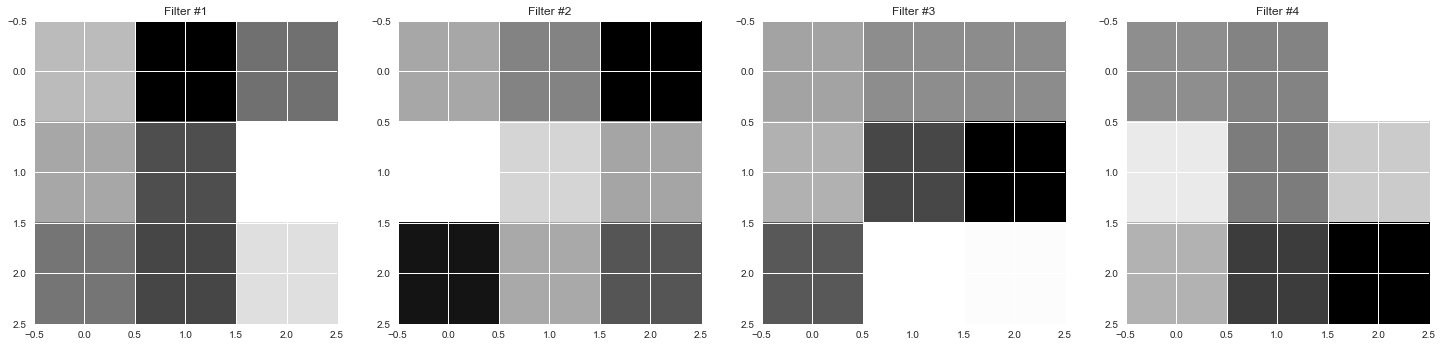

In [191]:
weight = model.model.layers[0].get_weights()[0][:,:,0,:]
plt.figure(1, figsize=(25,15))

for i in range(0,4):
    plt.subplot(1,4,i+1)
    plt.title('Filter #' + str(i+1))
    plt.imshow(weight[:,:,i],interpolation="nearest",cmap="gray")

print('\033[1m' + '1st Convolutional Layer')
plt.show()

2nd Convolutional Layer


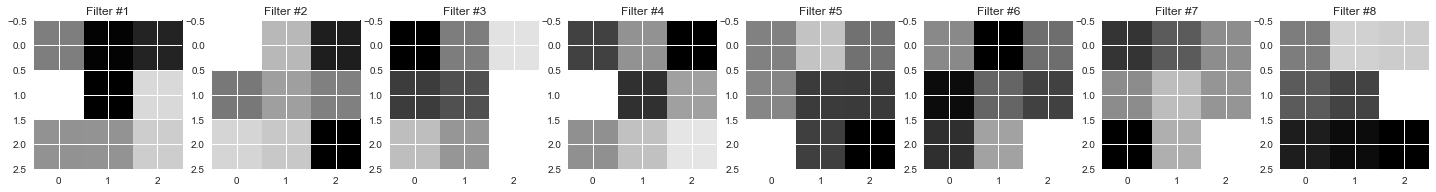

In [173]:
weight = model.model.layers[1].get_weights()[0][:,:,0,:]
plt.figure(1, figsize=(25,15))

for i in range(0,8):
    plt.subplot(1,8,i+1)
    plt.title('Filter #' + str(i+1))
    plt.imshow(weight[:,:,i],interpolation="nearest",cmap="gray")

print('\033[1m' + '2nd Convolutional Layer')
plt.show()

# View the heatmap average of all images that were trained

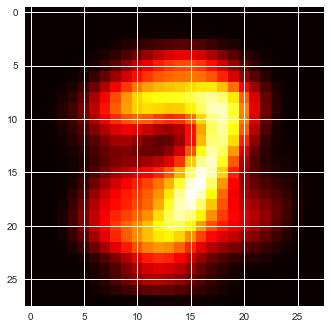

In [312]:
#get the average image of all of x_train samples
x_mean = np.mean(x_train,axis=0)

#print out shape of x_mean
x_mean.shape

#reshape x_mean for plotting
x_mean = np.reshape(x_mean,(28,28,1))

#plot x_mean
plt.imshow(x_mean[:,:,0],cmap='hot')